<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/m1_project/Examples/Creating_a_Dataset_Wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Dataset Wrapper

If you are having trouble getting your data into Colab for use with pytorch, this notebook might be for you. This will cover the case where it is not feasible to create a giant tensor with all of your images.  For instance, if you are trying to learn on a dataset with tens of thousands of images, the images will take up too much memory when decompressed.

Instead, we will write a dataset class that will allow pytorch to selectively decompress images when it needs them.  For our example, we're going to use the Caltech 256 dataset, which we've uploaded to Google Drive.

In [1]:
import gdown
gdown.download('https://drive.google.com/uc?authuser=0&id=1GMtKmoH2Yu9yY6jx4Mm5fZ1sLkGV9i_c&export=download',
               'caltech256.zip',
               quiet=False)
!unzip -qq caltech256.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1GMtKmoH2Yu9yY6jx4Mm5fZ1sLkGV9i_c&export=download
To: /content/caltech256.zip
1.15GB [00:07, 160MB/s]


replace 256_ObjectCategories/138.mattress/138_0117.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


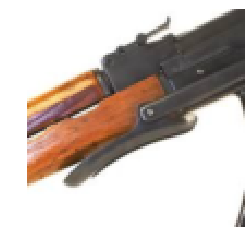

torch.Size([3, 100, 100])


In [12]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.datasets import VisionDataset
import os
from glob import glob
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

class Caltech256(VisionDataset):
    def __init__(self, transform=None, target_transform=None):
        super(Caltech256, self).__init__('.',
                                         transform=transform,
                                         target_transform=target_transform)
        self.categories = []
        self.index = []
        self.y = []
        for c in sorted(glob(os.path.join(self.root, "256_ObjectCategories",'???.*'))):
            _, category_dir = os.path.split(c)
            class_idx = int(category_dir[0:3]) - 1
            if class_idx >= 256:
                # skip the clutter category
                continue
            n = len(glob(os.path.join(self.root, "256_ObjectCategories", category_dir, '*.jpg')))
            self.categories.append(category_dir)
            self.index.extend(range(1, n + 1))
            self.y.extend(n * [class_idx])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # a gotcha is when some of the images are black and white, we can use
        # the convert('RGB') command to make sure everything is a three channel
        # RGB image.
        img = Image.open(os.path.join(self.root,
                                      "256_ObjectCategories",
                                      self.categories[self.y[index]],
                                      "{:03d}_{:04d}.jpg".format(self.y[index] + 1, self.index[index]))).convert('RGB')

        target = self.y[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img.float(), target
    def __len__(self):
        return len(self.index)


# center crop 200, 200 pixel patch and then resize to 100 by 100 for
# computational efficiency
cal_tech = Caltech256(transform=transforms.Compose([transforms.CenterCrop((200,200)),
                                                    transforms.Resize((100,100)),
                                                    transforms.ToTensor()]))

im, target = cal_tech[30]
show_image(im)
print(im.shape)

The rest is adapted from the other notebook on working with the COCO dataset.

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np

batch_size = 32
learning_rate = 3e-3
n_epochs = 8
image_dims = 3, 100, 100

In [0]:
import torch.optim as optim
import torch.nn as nn

class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        class_len = 256
        self.activation_func = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 512
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.maxpool_output_size = int(128 * (image_dims[1] / 20) * (image_dims[2] / 20))

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool5(self.conv3(x)))

        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

In [0]:
net = myCNN()
loss, optimizer = net.get_loss(learning_rate)

# Define some parameters to keep track of metrics
print_every = 20
test_every = 2000


In [0]:
import time
from torch.autograd import Variable

def test_loss(run_idx):
    # do a pass on the test set
    total_test_loss = 0
    idx = 0
    for inputs, labels in test_loader:

        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        idx += 1
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}".format(
        total_test_loss / (idx+1)))
idx = 0
train_hist_x = []
train_loss_hist = []
test_hist_x = []
test_loss_hist = []

n_train = 20000
indices = torch.randperm(len(cal_tech))

train_idx, test_idx = indices[:n_train], indices[n_train:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=train_sampler)


test_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=test_sampler)


device = 'cuda'
net.to(device)

for epoch in range(n_epochs):
    running_loss = 0.0
    start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        
        # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        # Compute the loss and find the loss with respect to each parameter of the model
        loss_size = loss(outputs, labels)
        loss_size.backward()
        
        # Change each parameter with respect to the recently computed loss.
        optimizer.step()

        # Update statistics
        running_loss += loss_size.data.item()
        
        # Print every 20th batch of an epoch
        if (i % print_every) == print_every-1:
            print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
                epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
            # Reset running loss and time
            train_loss_hist.append(running_loss / print_every)
            train_hist_x.append(idx)
            running_loss = 0.0
            start_time = time.time()
        # Check test set every nth batch
        if (i % test_every) == test_every -1:
            test_loss(idx)
            idx += 1

print("Training finished, took {:.2f}s".format(
    time.time() - training_start_time))

Epoch 1, Iteration 20	 train_loss: 5.5392 took: 2.8569s
Epoch 1, Iteration 40	 train_loss: 5.5021 took: 3.0422s
Epoch 1, Iteration 60	 train_loss: 5.4192 took: 2.6790s
Epoch 1, Iteration 80	 train_loss: 5.4187 took: 3.1818s
Epoch 1, Iteration 100	 train_loss: 5.3931 took: 2.9813s
Epoch 1, Iteration 120	 train_loss: 5.3568 took: 2.9217s
Epoch 1, Iteration 140	 train_loss: 5.3311 took: 2.9677s
Epoch 1, Iteration 160	 train_loss: 5.3943 took: 2.8755s
Epoch 1, Iteration 180	 train_loss: 5.3155 took: 2.8748s
Epoch 1, Iteration 200	 train_loss: 5.4462 took: 3.1629s
Epoch 1, Iteration 220	 train_loss: 5.3545 took: 3.0355s
Epoch 1, Iteration 240	 train_loss: 5.3342 took: 3.0870s
Epoch 1, Iteration 260	 train_loss: 5.2933 took: 3.0530s
Epoch 1, Iteration 280	 train_loss: 5.3264 took: 3.0441s
Epoch 1, Iteration 300	 train_loss: 5.3162 took: 3.0513s
Epoch 1, Iteration 320	 train_loss: 5.2900 took: 2.9648s
Epoch 1, Iteration 340	 train_loss: 5.2736 took: 2.9348s
Epoch 1, Iteration 360	 train_loss: